# PG Diploma in Machine Learning and AI from IIIT Bangalore | Upgrad

#### Developed by:
##### 1. Harsh Tiwari - Group facilitator
##### 2. Krishna Murthi B


## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [49]:
## Checking the GPU configuration

#!nvidia-smi

In [50]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc.pilutil import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [51]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30) 
#tf.random.set_seed

In [52]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [53]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [54]:
project_folder='Project_data'

##### Plotting

In [55]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [56]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [57]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [58]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_25 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 80, 80, 32)   

##### Sample Cropping

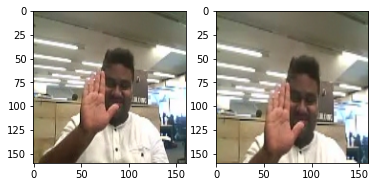

In [59]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [60]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [61]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [62]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 150s 7s/step - loss: 1.5412 - categorical_accuracy: 0.4374 - val_loss: 2.5727 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.57269, saving model to model_init_2022-10-0907_48_09.323119\model-00001-1.54115-0.43741-2.57269-0.16000.h5
Epoch 2/2
23/23 [==============================] - 130s 6s/step - loss: 0.9791 - categorical_accuracy: 0.6305 - val_loss: 4.7442 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 2.57269


In [63]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1277637
Epoch 1/2
34/34 [==============================] - 282s 8s/step - loss: 1.4522 - categorical_accuracy: 0.4525 - val_loss: 4.0531 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 4.05314, saving model to model_init_2022-10-0907_52_54.953543\model-00001-1.45222-0.45249-4.05314-0.22000.h5
Epoch 2/2
34/34 [==============================] - 260s 8s/step - loss: 0.9805 - categorical_accuracy: 0.6290 - val_loss: 7.0318 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 4.05314


In [64]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 3374789
Epoch 1/2
45/45 [==============================] - 624s 14s/step - loss: 1.4881 - categorical_accuracy: 0.4465 - val_loss: 15.2418 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 15.24183, saving model to model_init_2022-10-0908_02_34.185273\model-00001-1.48812-0.44646-15.24183-0.16000.h5
Epoch 2/2
45/45 [==============================] - 20450s 464s/step - loss: 0.9927 - categorical_accuracy: 0.6139 - val_loss: 26.1958 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 15.24183


In [65]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 333s 14s/step - loss: 1.3884 - categorical_accuracy: 0.4827 - val_loss: 1.9098 - val_categorical_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 1.90982, saving model to model_init_2022-10-0913_53_50.090240\model-00001-1.38844-0.48265-1.90982-0.28000.h5
Epoch 2/2
23/23 [==============================] - 318s 14s/step - loss: 0.8864 - categorical_accuracy: 0.6817 - val_loss: 2.6972 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.90982


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [66]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        
        model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [67]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_44 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_45 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 10, 80, 80, 32)  

In [68]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 482s 28s/step - loss: 1.5001 - categorical_accuracy: 0.4268 - val_loss: 2.7207 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.72066, saving model to model_init_2022-10-0914_04_46.573399\model-00001-1.50014-0.42685-2.72066-0.16000.h5
Epoch 2/15
17/17 [==============================] - 471s 28s/step - loss: 0.9110 - categorical_accuracy: 0.6440 - val_loss: 4.4001 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 2.72066
Epoch 3/15
17/17 [==============================] - 468s 28s/step - loss: 0.6391 - categorical_accuracy: 0.7541 - val_loss: 4.7512 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 2.72066
Epoch 4/15
17/17 [==============================] - 470s 28s/step - loss: 0.5067 - categorical_accuracy: 0.8281 - val_loss: 4.8080 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 2.72066
Epoch

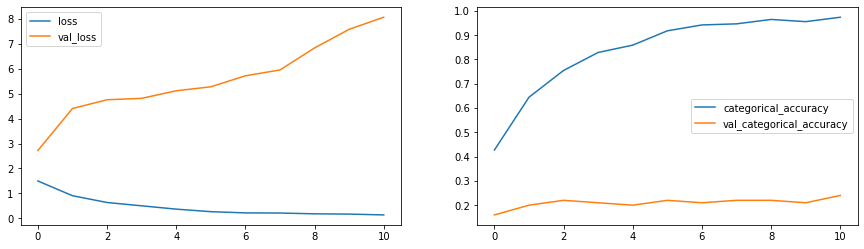

In [69]:
plot(history_model1)

##### Model is clearly overfitting. :(

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [70]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_49 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 10, 80, 80, 32)  

In [71]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 710s 21s/step - loss: 2.0409 - categorical_accuracy: 0.3544 - val_loss: 4.8091 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 4.80911, saving model to model_init_2022-10-0915_21_28.996537\model-00001-2.04085-0.35445-4.80911-0.21000.h5
Epoch 2/25
34/34 [==============================] - 713s 21s/step - loss: 1.4269 - categorical_accuracy: 0.5075 - val_loss: 11.0641 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 4.80911
Epoch 3/25
34/34 [==============================] - 710s 21s/step - loss: 1.1752 - categorical_accuracy: 0.5852 - val_loss: 8.7354 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 4.80911
Epoch 4/25
34/34 [==============================] - 710s 21s/step - loss: 0.9725 - categorical_accuracy: 0.6538 - val_loss: 9.0538 - val_categorical_accuracy: 0.2600

Epoch 00004: val_loss did not improve from 4.80911
Epoc

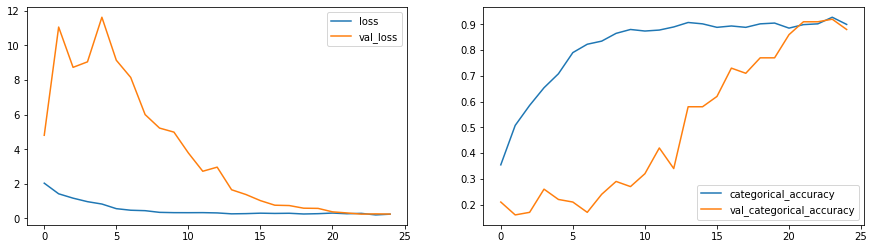

In [72]:
plot(history_model2)

##### We can see  val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 15/25!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [73]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [74]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_52 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_52 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_53 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 8, 60, 60, 32)   

In [75]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 243s 11s/step - loss: 2.0772 - categorical_accuracy: 0.3416 - val_loss: 1.7316 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.73159, saving model to model_init_2022-10-0920_17_51.127759\model-00001-2.07719-0.34163-1.73159-0.16000.h5
Epoch 2/25
23/23 [==============================] - 238s 10s/step - loss: 1.4703 - categorical_accuracy: 0.5015 - val_loss: 2.5606 - val_categorical_accuracy: 0.1400

Epoch 00002: val_loss did not improve from 1.73159
Epoch 3/25
23/23 [==============================] - 236s 10s/step - loss: 1.1772 - categorical_accuracy: 0.5845 - val_loss: 3.4779 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.73159
Epoch 4/25
23/23 [==============================] - 235s 10s/step - loss: 1.0102 - categorical_accuracy: 0.6388 - val_loss: 4.4958 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 1.73159
Epoch

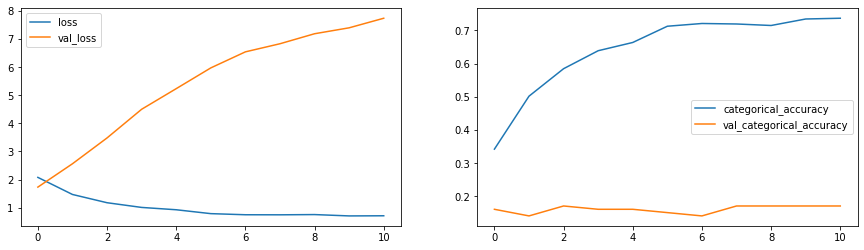

In [76]:
plot(history_model3)

##### Model has a  best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [77]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam()
        model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [78]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_56 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_56 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_56 (MaxPooling (None, 8, 60, 60, 16)   

In [79]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 851s 25s/step - loss: 2.0589 - categorical_accuracy: 0.3198 - val_loss: 2.9049 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 2.90491, saving model to model_init_2022-10-0921_01_24.264902\model-00001-2.05892-0.31976-2.90491-0.22000.h5
Epoch 2/25
34/34 [==============================] - 847s 25s/step - loss: 1.6660 - categorical_accuracy: 0.4329 - val_loss: 6.7293 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss did not improve from 2.90491
Epoch 3/25
34/34 [==============================] - 855s 25s/step - loss: 1.3438 - categorical_accuracy: 0.5317 - val_loss: 3.3679 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 2.90491
Epoch 4/25
34/34 [==============================] - 858s 25s/step - loss: 1.3039 - categorical_accuracy: 0.5498 - val_loss: 1.7321 - val_categorical_accuracy: 0.2900

Epoch 00004: val_loss improved from 2.90491 to 1.73213, 

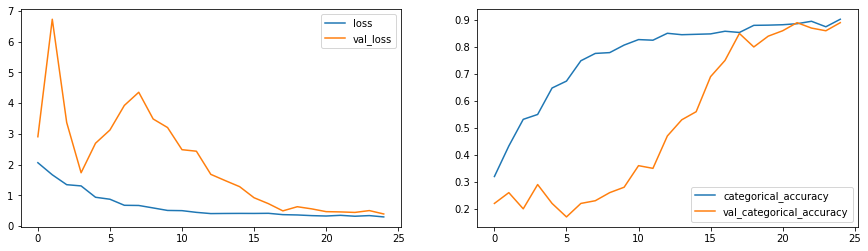

In [80]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [81]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        
        model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [82]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_64 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_64 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_88 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 8, 60, 60, 16)   

In [83]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 864s 25s/step - loss: 1.7560 - categorical_accuracy: 0.3914 - val_loss: 2.6153 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.61532, saving model to model_init_2022-10-1002_56_46.777845\model-00001-1.75605-0.39140-2.61532-0.21000.h5
Epoch 2/15
34/34 [==============================] - 865s 25s/step - loss: 1.3252 - categorical_accuracy: 0.4894 - val_loss: 3.3081 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 2.61532
Epoch 3/15
34/34 [==============================] - 861s 25s/step - loss: 1.0103 - categorical_accuracy: 0.6267 - val_loss: 2.8701 - val_categorical_accuracy: 0.1500

Epoch 00003: val_loss did not improve from 2.61532
Epoch 4/15
34/34 [==============================] - 859s 25s/step - loss: 0.7069 - categorical_accuracy: 0.7345 - val_loss: 2.7123 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 2.61532
Epoch

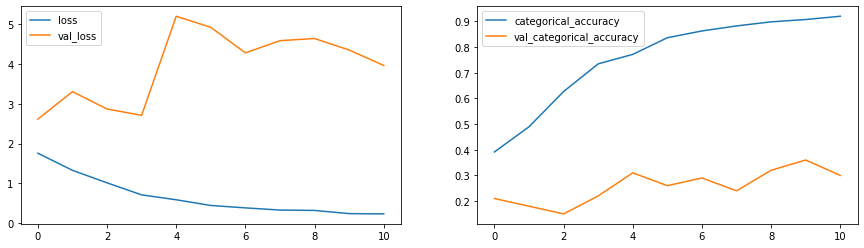

In [84]:
plot(history_model5)

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [85]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [86]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_72 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_72 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_73 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 8, 50, 50, 32)   

In [87]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - 193s 6s/step - loss: 1.7348 - categorical_accuracy: 0.3748 - val_loss: 2.0201 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.02011, saving model to model_init_2022-10-1005_34_27.885057\model-00001-1.73480-0.37481-2.02011-0.21000.h5
Epoch 2/20
34/34 [==============================] - 192s 6s/step - loss: 1.1522 - categorical_accuracy: 0.5732 - val_loss: 2.9939 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 2.02011
Epoch 3/20
34/34 [==============================] - 194s 6s/step - loss: 0.9714 - categorical_accuracy: 0.6493 - val_loss: 4.9239 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 2.02011
Epoch 4/20
34/34 [==============================] - 193s 6s/step - loss: 0.8152 - categorical_accuracy: 0.6893 - val_loss: 5.0377 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 2.02011
Epoch 5/20

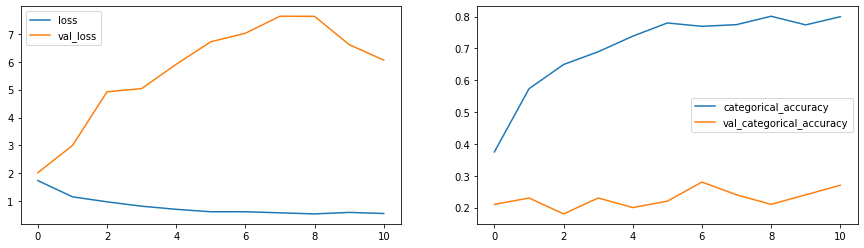

In [88]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 74%

## Model 7 - Reducing the number of parameters again

In [89]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [90]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_76 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_76 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_68 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_77 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_77 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 8, 60, 60, 32)   

In [91]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 313s 9s/step - loss: 1.8176 - categorical_accuracy: 0.3333 - val_loss: 1.9062 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 1.90624, saving model to model_init_2022-10-1006_09_53.761157\model-00001-1.81765-0.33333-1.90624-0.26000.h5
Epoch 2/25
34/34 [==============================] - 312s 9s/step - loss: 1.1359 - categorical_accuracy: 0.5437 - val_loss: 2.7731 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.90624
Epoch 3/25
34/34 [==============================] - 312s 9s/step - loss: 0.9748 - categorical_accuracy: 0.6448 - val_loss: 4.0538 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.90624
Epoch 4/25
34/34 [==============================] - 312s 9s/step - loss: 0.7943 - categorical_accuracy: 0.7051 - val_loss: 4.4367 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 1.90624
Epoch 5/25

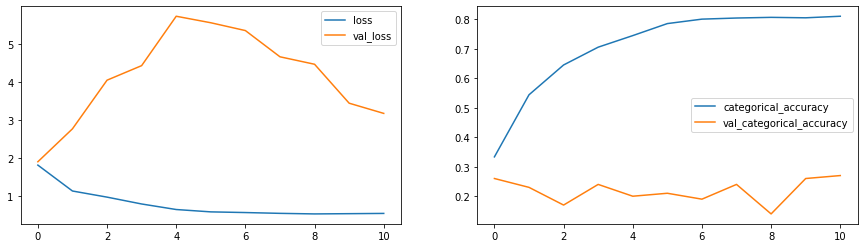

In [92]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 73%

## Model 8 - CNN- LSTM Model

In [93]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        # optimiser = optimizers.Adam()
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [94]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)  

In [95]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 219s 6s/step - loss: 1.4147 - categorical_accuracy: 0.3922 - val_loss: 1.6570 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.65703, saving model to model_init_2022-10-1007_07_11.797096\model-00001-1.41470-0.39216-1.65703-0.21000.h5
Epoch 2/20
34/34 [==============================] - 194s 6s/step - loss: 1.0496 - categorical_accuracy: 0.5965 - val_loss: 1.7405 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.65703
Epoch 3/20
34/34 [==============================] - 192s 6s/step - loss: 0.8328 - categorical_accuracy: 0.7029 - val_loss: 1.8169 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.65703
Epoch 4/20
34/34 [==============================] - 192s 6s/step - loss: 0.6750 - categorical_accuracy: 0.7685 - val_loss: 1.8176 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.65703
Epoch 5/2

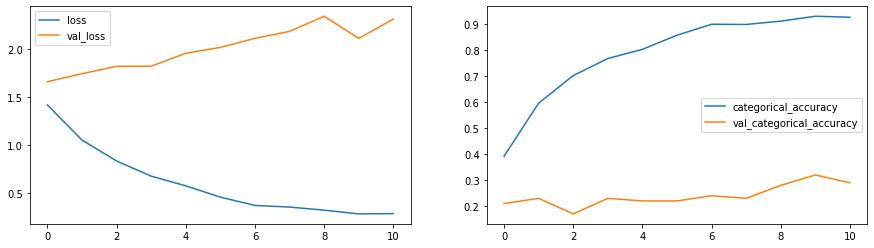

In [96]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 85%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [97]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

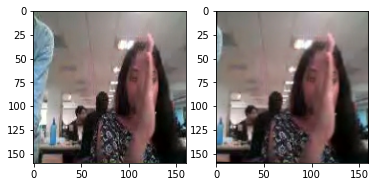

In [98]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [99]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [100]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_80 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_80 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_72 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_81 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_81 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 10, 80, 80, 32)  

In [101]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - 712s 21s/step - loss: 1.9462 - categorical_accuracy: 0.3778 - val_loss: 2.1432 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1007_43_10.017917\model-00001-1.94621-0.37783-2.14317-0.21000.h5
Epoch 2/20
34/34 [==============================] - 710s 21s/step - loss: 1.4567 - categorical_accuracy: 0.5053 - val_loss: 3.7577 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2022-10-1007_43_10.017917\model-00002-1.45665-0.50528-3.75767-0.22000.h5
Epoch 3/20
34/34 [==============================] - 712s 21s/step - loss: 1.2115 - categorical_accuracy: 0.5535 - val_loss: 5.0590 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2022-10-1007_43_10.017917\model-00003-1.21150-0.55354-5.05901-0.20000.h5
Epoch 4/20
34/34 [==============================] - 711s 21s/step - loss: 1.0332 - categorical_accuracy: 0.6335 - val_loss: 7.3675 - val_c

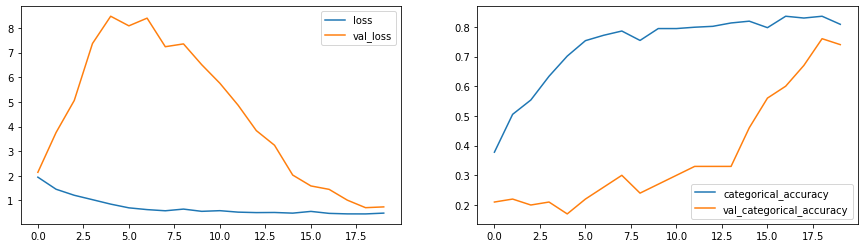

In [102]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [103]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [104]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_84 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_84 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_76 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_85 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_122 (Bat (None, 8, 60, 60, 32)   

In [105]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 243s 11s/step - loss: 2.1366 - categorical_accuracy: 0.3341 - val_loss: 1.7894 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2022-10-1011_40_18.797680\model-00001-2.13659-0.33409-1.78937-0.23000.h5
Epoch 2/25
23/23 [==============================] - 241s 10s/step - loss: 1.4294 - categorical_accuracy: 0.5158 - val_loss: 2.6770 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2022-10-1011_40_18.797680\model-00002-1.42944-0.51584-2.67700-0.18000.h5
Epoch 3/25
23/23 [==============================] - 241s 10s/step - loss: 1.0860 - categorical_accuracy: 0.6176 - val_loss: 3.5557 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to model_init_2022-10-1011_40_18.797680\model-00003-1.08599-0.61765-3.55574-0.17000.h5
Epoch 4/25
23/23 [==============================] - 241s 10s/step - loss: 1.0183 - categorical_accuracy: 0.6380 - val_loss: 5.0914 - val_c

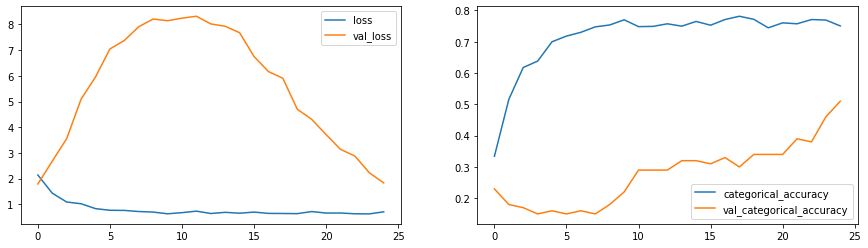

In [106]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [107]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [108]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_88 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_88 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_127 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_89 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_89 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_80 (MaxPooling (None, 8, 60, 60, 16)   

In [109]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 855s 25s/step - loss: 2.0864 - categorical_accuracy: 0.3311 - val_loss: 1.8977 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1013_21_33.182719\model-00001-2.08638-0.33107-1.89766-0.21000.h5
Epoch 2/25
34/34 [==============================] - 856s 25s/step - loss: 1.5217 - categorical_accuracy: 0.4721 - val_loss: 2.3486 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2022-10-1013_21_33.182719\model-00002-1.52171-0.47210-2.34859-0.19000.h5
Epoch 3/25
34/34 [==============================] - 856s 25s/step - loss: 1.2432 - categorical_accuracy: 0.5520 - val_loss: 2.8568 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2022-10-1013_21_33.182719\model-00003-1.24318-0.55204-2.85681-0.22000.h5
Epoch 4/25
34/34 [==============================] - 856s 25s/step - loss: 1.0185 - categorical_accuracy: 0.6297 - val_loss: 3.1882 - val_c

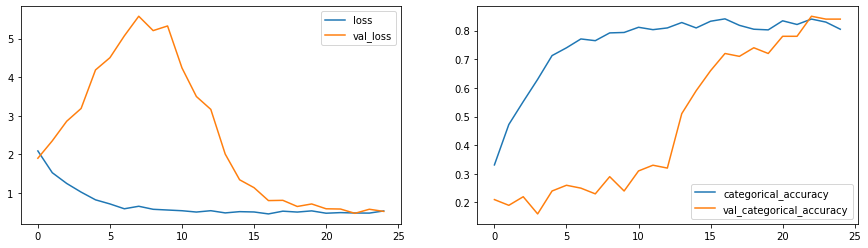

In [110]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [111]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [112]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_96 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_96 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_137 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_97 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_138 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_84 (MaxPooling (None, 8, 60, 60, 16)   

In [113]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 861s 25s/step - loss: 2.1406 - categorical_accuracy: 0.2692 - val_loss: 2.1107 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1019_19_34.986775\model-00001-2.14059-0.26923-2.11073-0.21000.h5
Epoch 2/25
34/34 [==============================] - 861s 25s/step - loss: 1.6463 - categorical_accuracy: 0.4050 - val_loss: 2.6455 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-10-1019_19_34.986775\model-00002-1.64631-0.40498-2.64553-0.20000.h5
Epoch 3/25
34/34 [==============================] - 865s 25s/step - loss: 1.4889 - categorical_accuracy: 0.4404 - val_loss: 3.1666 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2022-10-1019_19_34.986775\model-00003-1.48885-0.44042-3.16663-0.25000.h5
Epoch 4/25
34/34 [==============================] - 864s 25s/step - loss: 1.3211 - categorical_accuracy: 0.5015 - val_loss: 4.7940 - val_c

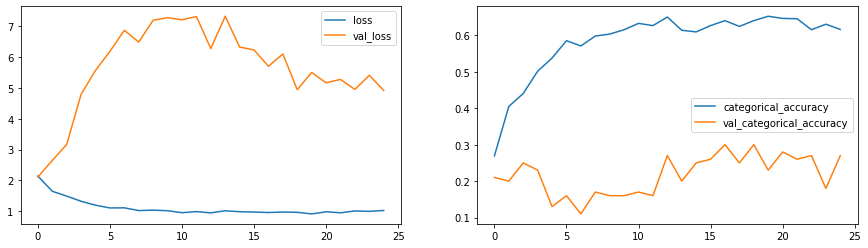

In [114]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [115]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [116]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_104 (Conv3D)          (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_104 (Activation)  (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_147 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_88 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_105 (Activation)  (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_148 (Bat (None, 8, 50, 50, 32)   

In [117]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - 193s 6s/step - loss: 1.7877 - categorical_accuracy: 0.3605 - val_loss: 1.7436 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1101_19_39.617625\model-00001-1.78775-0.36048-1.74364-0.21000.h5
Epoch 2/25
34/34 [==============================] - 193s 6s/step - loss: 1.1543 - categorical_accuracy: 0.5641 - val_loss: 2.7308 - val_categorical_accuracy: 0.1400

Epoch 00002: saving model to model_init_2022-10-1101_19_39.617625\model-00002-1.15431-0.56410-2.73078-0.14000.h5
Epoch 3/25
34/34 [==============================] - 193s 6s/step - loss: 0.9516 - categorical_accuracy: 0.6275 - val_loss: 3.7720 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2022-10-1101_19_39.617625\model-00003-0.95165-0.62745-3.77199-0.18000.h5
Epoch 4/25
34/34 [==============================] - 192s 6s/step - loss: 0.7963 - categorical_accuracy: 0.6991 - val_loss: 5.9169 - val_catego

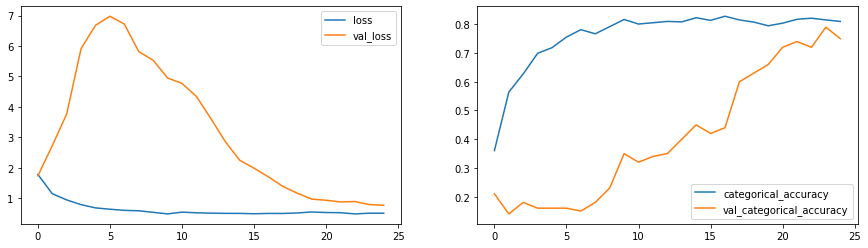

In [118]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [119]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [120]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_108 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_108 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_153 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_92 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_109 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_154 (Bat (None, 8, 60, 60, 32)   

In [121]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 315s 9s/step - loss: 1.6745 - categorical_accuracy: 0.3922 - val_loss: 2.1267 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1102_40_12.111654\model-00001-1.67447-0.39216-2.12666-0.21000.h5
Epoch 2/25
34/34 [==============================] - 314s 9s/step - loss: 1.1326 - categorical_accuracy: 0.5573 - val_loss: 3.3507 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2022-10-1102_40_12.111654\model-00002-1.13259-0.55732-3.35069-0.23000.h5
Epoch 3/25
34/34 [==============================] - 313s 9s/step - loss: 0.9188 - categorical_accuracy: 0.6433 - val_loss: 5.0614 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to model_init_2022-10-1102_40_12.111654\model-00003-0.91882-0.64329-5.06143-0.17000.h5
Epoch 4/25
34/34 [==============================] - 313s 9s/step - loss: 0.8683 - categorical_accuracy: 0.6931 - val_loss: 5.9109 - val_catego

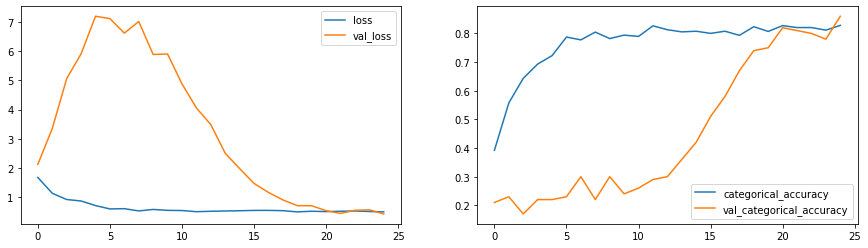

In [122]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [123]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        # optimiser = optimizers.Adam(lr=0.0002)
        model.compile(tf.optimizers.Adam(0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [124]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)  

In [125]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - 221s 7s/step - loss: 1.3663 - categorical_accuracy: 0.4314 - val_loss: 1.8104 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-10-1104_51_07.145513\model-00001-1.36631-0.43137-1.81045-0.21000.h5
Epoch 2/20
34/34 [==============================] - 212s 6s/step - loss: 0.9372 - categorical_accuracy: 0.6410 - val_loss: 2.3402 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2022-10-1104_51_07.145513\model-00002-0.93723-0.64103-2.34023-0.23000.h5
Epoch 3/20
34/34 [==============================] - 234s 7s/step - loss: 0.7729 - categorical_accuracy: 0.7074 - val_loss: 2.5637 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2022-10-1104_51_07.145513\model-00003-0.77292-0.70739-2.56369-0.24000.h5
Epoch 4/20
34/34 [==============================] - 197s 6s/step - loss: 0.6015 - categorical_accuracy: 0.7911 - val_loss: 2.8629 - val_categ

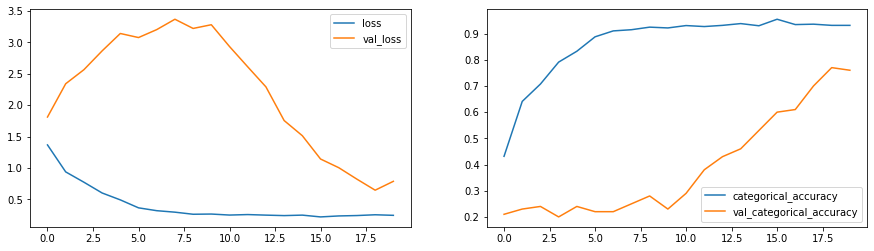

In [126]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 16 - Let us bring in Transfer Learning !! :)
__(Optional)__

In [127]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [128]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        # optimiser = optimizers.Adam()
        model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 1s 0us/step


In [129]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)             

In [130]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 160s 1s/step - loss: 1.1910 - categorical_accuracy: 0.5226 - val_loss: 0.7859 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to model_init_2022-10-1105_59_29.297669\model-00001-1.19103-0.52262-0.78589-0.71000.h5
Epoch 2/20
133/133 [==============================] - 136s 1s/step - loss: 0.6634 - categorical_accuracy: 0.7579 - val_loss: 0.6174 - val_categorical_accuracy: 0.7700

Epoch 00002: saving model to model_init_2022-10-1105_59_29.297669\model-00002-0.66337-0.75792-0.61736-0.77000.h5
Epoch 3/20
133/133 [==============================] - 136s 1s/step - loss: 0.4657 - categorical_accuracy: 0.8514 - val_loss: 0.5597 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2022-10-1105_59_29.297669\model-00003-0.46575-0.85143-0.55972-0.80000.h5
Epoch 4/20
133/133 [==============================] - 137s 1s/step - loss: 0.3773 - categorical_accuracy: 0.8597 - val_loss: 0.5502 - v

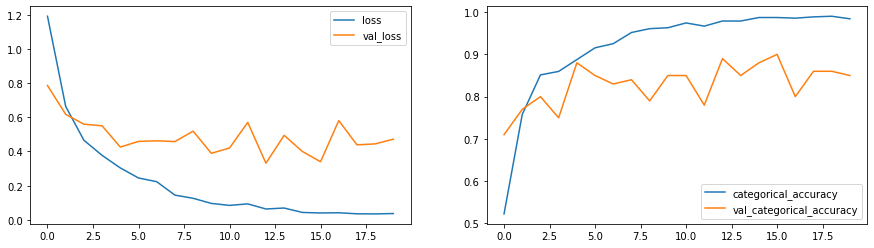

In [131]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
__(Optional)__

In [132]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        # optimiser = optimizers.Adam()
        model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [133]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)             

In [134]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - 418s 3s/step - loss: 0.8705 - categorical_accuracy: 0.6644 - val_loss: 0.4400 - val_categorical_accuracy: 0.8700

Epoch 00001: saving model to model_init_2022-10-1106_45_47.189215\model-00001-0.87050-0.66440-0.43998-0.87000.h5
Epoch 2/20
133/133 [==============================] - 414s 3s/step - loss: 0.3932 - categorical_accuracy: 0.8673 - val_loss: 0.3885 - val_categorical_accuracy: 0.9000

Epoch 00002: saving model to model_init_2022-10-1106_45_47.189215\model-00002-0.39316-0.86727-0.38852-0.90000.h5
Epoch 3/20
133/133 [==============================] - 413s 3s/step - loss: 0.2268 - categorical_accuracy: 0.9261 - val_loss: 0.4019 - val_categorical_accuracy: 0.8800

Epoch 00003: saving model to model_init_2022-10-1106_45_47.189215\model-00003-0.22679-0.92609-0.40190-0.88000.h5
Epoch 4/20
133/133 [==============================] - 412s 3s/step - loss: 0.2408 - categorical_accuracy: 0.9201 - val_loss: 0.0491 - v

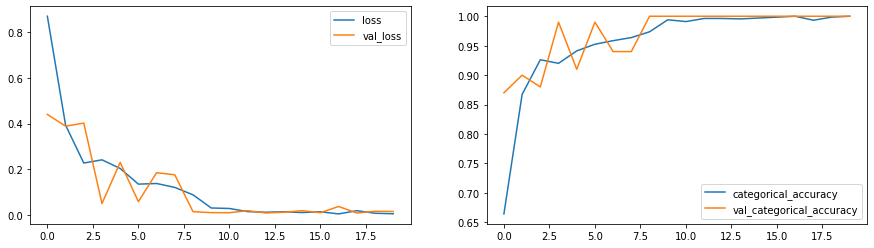

In [135]:
plot(history_model17)

### Awesome results! 100% Training accuracy :)

# Consolidated Final Models

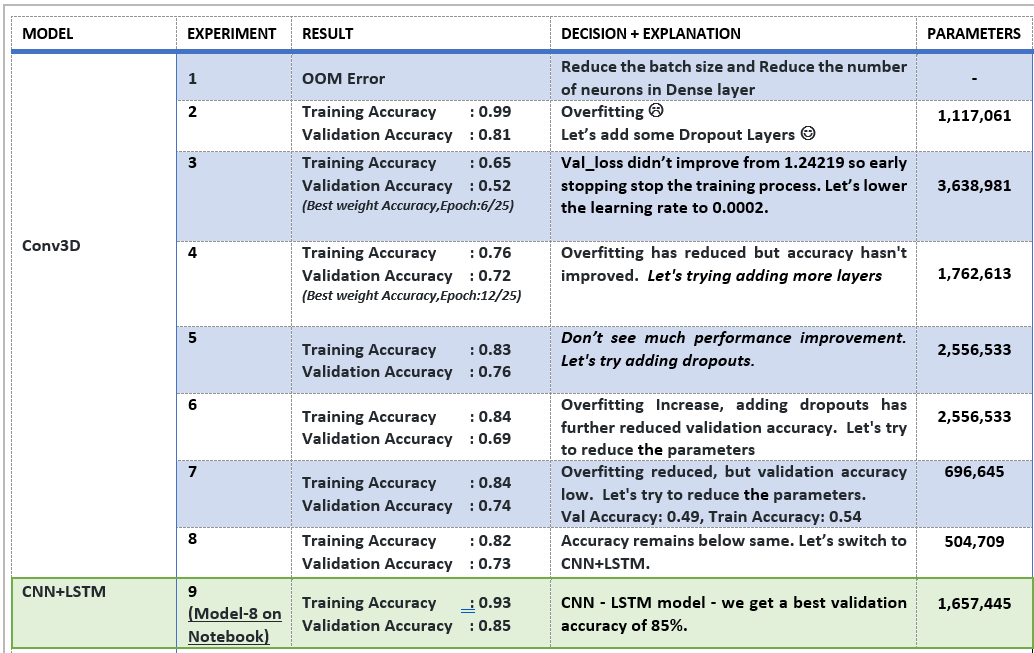
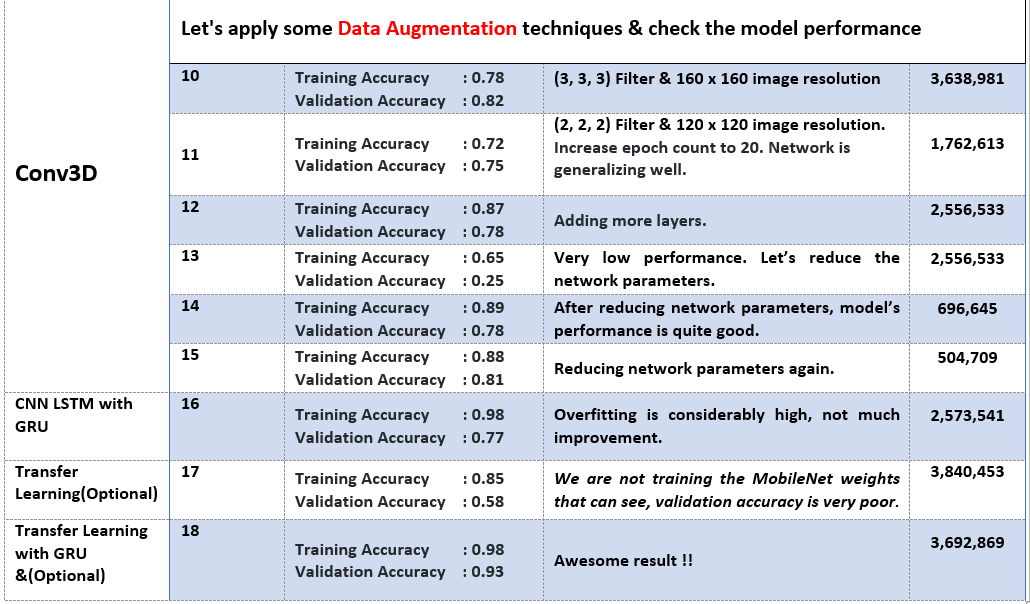

## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 100%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model_init_2022-10-1106_45_47.189215\model-00020-0.00432-1.00000-0.01437-1.00000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [137]:
import time
from keras.models import load_model
model = load_model('model_init_2022-10-1106_45_47.189215\model-00020-0.00432-1.00000-0.01437-1.00000.h5')

In [138]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [139]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [140]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 3 3 0 1 1 4 2 3 3 3 1 0 4 4 3 1 0 1 2]


In [1]:
############################################################################################################################
#                                                                                                                          #               
#                                                 Compiled By:                                                             #
#                                                1. Harsh Tiwari - Group Facilitator                                       #
#                                                2. Krishna Murthi B                                                       #
############################################################################################################################

!pip freeze >requirement.txt